# Analyzing extreme precipitation events in Saxony from 2002 to 2006

$\rightarrow$ This timeframe contains some of the heaviest rainfall recorded in Germany. 

In [1]:
library(dplyr)
library(stringr)
library(ggplot2)
library(tibble)
library(rdwd)
data(geoIndex)
library(data.table)
library(ggmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.



In [2]:
# helper function to standardize column names
id_int_to_colname <- function(id) {
    if(id < 1) stop("ID not allowed")
    if(id < 10) return(paste0("SDO_0000", id)) 
    else if (id < 100) return(paste0("SDO_000", id)) 
    else if (id < 1000) return(paste0("SDO_00", id)) 
    else if (id < 10000) return(paste0("SDO_0", id)) 
    else if (id < 100000) return(paste0("SDO_", id)) 
} 

# Simple preprocessing of the data 

In [3]:
# load data and remove trailing column
rain_df <- read.csv("./data/precip_germany_2002_2006_clean.csv") %>% as_tibble()
rain_df <- rain_df %>% select(-X)

# create useful dataframes for geodata for maps later
names(rain_df)[2:ncol(rain_df)] <- sapply(names(rain_df)[2:ncol(rain_df)], function(x) str_replace(x, "X", "SDO_"))
mygeoIndex <- geoIndex[sapply(geoIndex$id, id_int_to_colname) %in% colnames(rain_df),]

In [4]:
# filter for saxony data
sachsen_geodat <- mygeoIndex %>% filter(state == "Sachsen")
sachsen_colnames <- sapply(sachsen_geodat$id, id_int_to_colname)
rain_df_sachsen <- rain_df %>% select(date, all_of(sachsen_colnames))

# filter for city specific data for Dresden by geographic specifications (lat and lon)
dresden_geodat <- sachsen_geodat %>% filter(lat < 51.6) %>% filter(lat > 50.5) %>% filter(lon < 14.4) %>% filter(lon > 13.3)
colnames <- sapply(dresden_geodat$id, id_int_to_colname)
rain_df_dresden <- rain_df[, c("date", colnames)]

# This is how the geodata looks like

In [5]:
head(dresden_geodat)

id   name                  state   lat     lon     ele nfiles nonpublic
1 4432 Altenberg-Schellerhau Sachsen 50.7799 13.6814 778  6     0        
2  457 Berthelsdorf          Sachsen 51.0571 14.2283 342  3     3        
3  483 Bielatal              Sachsen 50.8732 14.0382 364  4     2        
4  822 Burkau-Kleinhaenchen  Sachsen 51.2066 14.2371 205  6     0        
5  878 Coswig                Sachsen 51.1178 13.5731 110  6     0        
6 1048 Dresden-Klotzsche     Sachsen 51.1280 13.7543 227 93     1        
  recentfile
1  TRUE     
2 FALSE     
3  TRUE     
4  TRUE     
5  TRUE     
6  TRUE     
  display                                                                                                                                                                         
1 rdwd::metaInfo(id=4432)<br>name: Altenberg-Schellerhau<br>state: Sachsen<br>lat: 50.7799<br>lon: 13.6814<br>ele:  778<br>n public files:  6<br>nonpublic:  0<br>recentfile: TRUE
2 rdwd::metaInfo(id=457)<br>name: Berthelsdorf<br>state: Sachsen<br>lat: 51.0571<br>lon: 14.2283<br>ele:  342<br>n public files:  3<br>nonpublic:  3<br>recentfile: FALSE         
3 rdwd::metaInfo(id=483)<br>name: Bielatal<br>state: Sachsen<br>lat: 50.8732<br>lon: 14.0382<br>ele:  364<br>n public files:  4<br>nonpublic:  2<br>recentfile: TRUE              
4 rdwd::metaInfo(id=822)<br>name: Burkau-Kleinhaenchen<br>state: Sachsen<br>lat: 51.2066<br>lon: 14.2371<br>ele:  205<br>n public files:  6<br>nonpublic:  0<br>recentfile: TRUE  
5 rdwd::metaInfo(id=878)<br>name: Coswig<br>state: Sachsen<br>lat: 51.1178<br>lon: 13.5731<br>ele:  110<br>n public files:  6<br>nonpublic:  0<br>recentfile: TRUE                
6 rdwd::metaInfo(id=1048)<br>name: Dresden-Klotzsche<br>state: Sachsen<br>lat: 51.1280<br>lon: 13.7543<br>ele:  227<br>n public files: 93<br>nonpublic:  1<br>recentfile: TRUE    
  col 
1 blue
2 red 
3 blue
4 blue
5 blue
6 blue

In [9]:
invisible(dresden_map <- get_stamenmap(
        bbox = c(left = 13.3, bottom = 50.55, right = 14.4, top = 51.4), 
        maptype = "terrain", zoom = 12))

221 tiles needed, this may take a while (try a smaller zoom).



# Last data preparation, drop columns with non relevant data

In [10]:
# AN ALTERNATIVE DATA PROCESSING BY JUST TRANSFORMING EXTREME EVENTS W.R.T AN EXCEEDANCE
# daily_total_precip <- rain_df_dresden %>% select(- date) %>% rowSums
# print(quantile(daily_total_precip, 0.8))
# rain_df_dresden_extreme <- rain_df_dresden[which(daily_total_precip > 80.5), ]

data_pca <- rain_df_dresden %>% select(-date)

# An example useage of the package

In [11]:
library(maxstablePCA)

# transform data in analogy to K-means, b ut so far its using the 1 norm instead of euclidean 
data_pca_f1 <- transform_unitfrechet(data_pca)

# fit a max stable PCA with p = 5 as latent encoding
# the standard threshold for the estimation of the STD is s = 3, 
# corresponding roughly to the top ~30% of extreme data.
maxPCA <- max_stable_prcomp(data_pca_f1, 5, n_initial_guesses = 300)

# view some basic summaries
summary(maxPCA)

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.



$p
[1] 5

$d
[1] 25

$decoder_matrix
             [,1]        [,2]        [,3]        [,4]        [,5]
 [1,] 0.429029413 0.017259455 0.026059690 0.068992119 0.008951416
 [2,] 0.014833013 0.010652004 0.003904790 0.712172734 0.010744260
 [3,] 0.033180343 0.003669875 0.003522171 0.008016284 0.512896416
 [4,] 0.035110287 0.476143206 0.005896238 0.017225019 0.004769136
 [5,] 0.025854858 0.750735185 0.017570735 0.006951339 0.012351811
 [6,] 0.014578888 0.002420901 0.394025919 0.008793782 0.060087238
 [7,] 0.036972884 0.014816121 0.676108473 0.004654327 0.012232861
 [8,] 0.004879031 0.019329280 0.415499771 0.022110933 0.003623233
 [9,] 0.007710211 0.006134445 0.387418125 0.003714930 0.007457117
[10,] 0.089263250 0.009529905 0.005404697 0.304547265 0.020812811
[11,] 0.245814421 0.336684432 0.003451067 0.007001276 0.006850854
[12,] 0.091102618 0.004394479 0.002002423 0.311284007 0.019895326
[13,] 0.010305118 0.538194696 0.010590055 0.008551904 0.008928130
[14,] 0.744797782 0.007427386 0.0032156

# The encoder matrix can be understood as the loadings

In [13]:
maxPCA$encoder_matrix

[,1]        [,2]       [,3]        [,4]        [,5]       [,6]       
[1,] 0.010944915 0.07438541 0.009385820 0.006477382 0.01583488 0.008593810
[2,] 0.005930086 0.35542306 0.003481484 0.114379343 1.33202863 0.004439915
[3,] 0.028770888 0.39952634 0.008849008 0.143867327 0.05021574 0.008574276
[4,] 0.103288360 1.40415830 0.020149413 0.169118397 0.01758508 0.055787012
[5,] 0.014419707 0.01326247 1.949708914 0.003570601 0.01321412 0.013852431
     [,7]       [,8]       [,9]       [,10]      [,11] [,12]       [,13]     
[1,] 0.01616757 0.07088753 0.01259615 0.01424511 ⋯     0.004013921 0.07852402
[2,] 0.04116201 0.01684845 0.01584749 0.00479893 ⋯     0.010883759 0.01568277
[3,] 1.47904710 0.00762248 0.32804057 0.08082516 ⋯     0.027338067 0.10635463
[4,] 0.01871460 0.03176270 0.02075686 0.03156536 ⋯     0.016199702 0.14248290
[5,] 0.01269721 0.03141203 0.02048904 0.01482913 ⋯     0.004446023 0.03058257
     [,14]       [,15]      [,16]      [,17]       [,18]       [,19]     
[1,] 0.021712710 0.02303484 0.01861540 0.034125368 0.032913064 0.01080124
[2,] 0.003277845 0.00339144 0.05400551 0.015701741 0.013199246 0.01522616
[3,] 0.001941866 0.12424584 0.04070237 0.042916544 0.103996182 0.08962815
[4,] 0.006427285 0.04549550 0.01407426 0.006918298 0.002267759 0.09077122
[5,] 0.051799283 0.02451781 0.02082460 0.010842316 0.030250243 0.03695939
     [,20]       [,21]     
[1,] 0.003962394 1.34260188
[2,] 0.018194409 0.02240524
[3,] 0.233353088 0.03838404
[4,] 0.009768649 0.03560522
[5,] 0.004777402 0.08671547

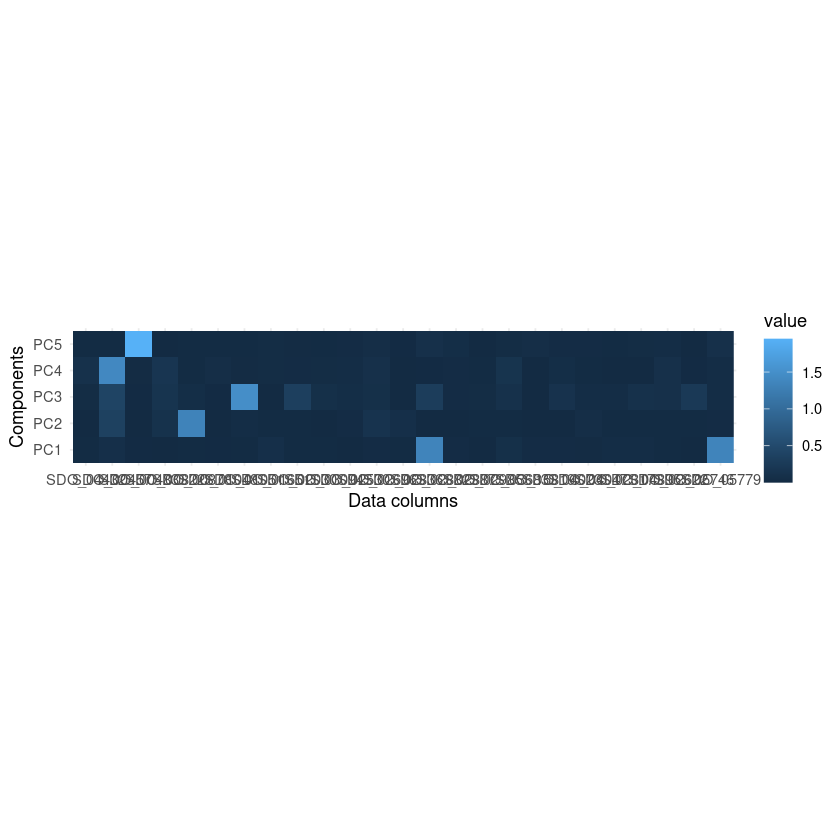

In [52]:
library(reshape2)

enc <- maxPCA$encoder_matrix
row.names(enc) <- paste0("PC", 1:5)
colnames(enc) <- colnames(data_pca_f1)

ggplot(melt(t(enc)), aes(Var1,Var2, fill=value)) +
geom_raster() + 
xlab("Data columns") + 
ylab("Components") +
coord_fixed() +
theme_minimal()

# Mapping the spatial distribution of the loadings

In [82]:
create_map_by_loadings <- function(index_pc) {
    
    internal_geodat <- dresden_geodat
    internal_geodat$value <- 0
    
    for(i in 1:dim(dresden_geodat)[1]) {
        internal_geodat$value[i] <- enc[index_pc, id_int_to_colname(internal_geodat$id[i])]
    }
     
    map <- ggmap(dresden_map) +
    geom_point(internal_geodat, mapping = aes(x = lon, y = lat, size = 2.5, color = value)) + 
    scale_color_gradient2(low = "#100000", mid = "#666364", high = "#D13F58") + 
    labs(title = paste("Loadings for PC", index_pc)) +
    theme_minimal()
    
    map
}

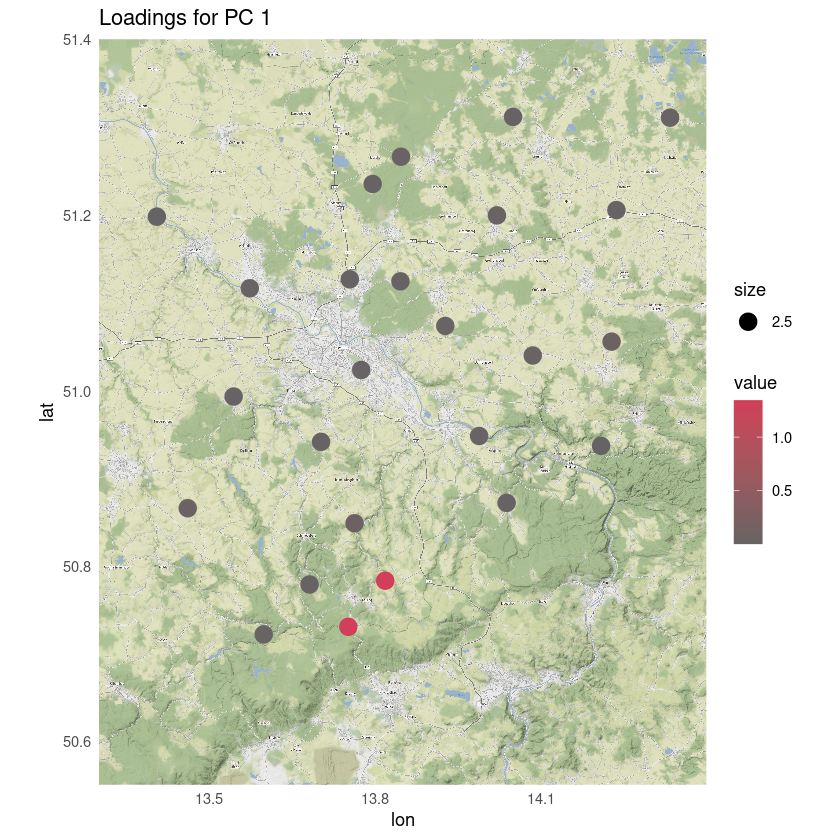

In [83]:
create_map_by_loadings(1)

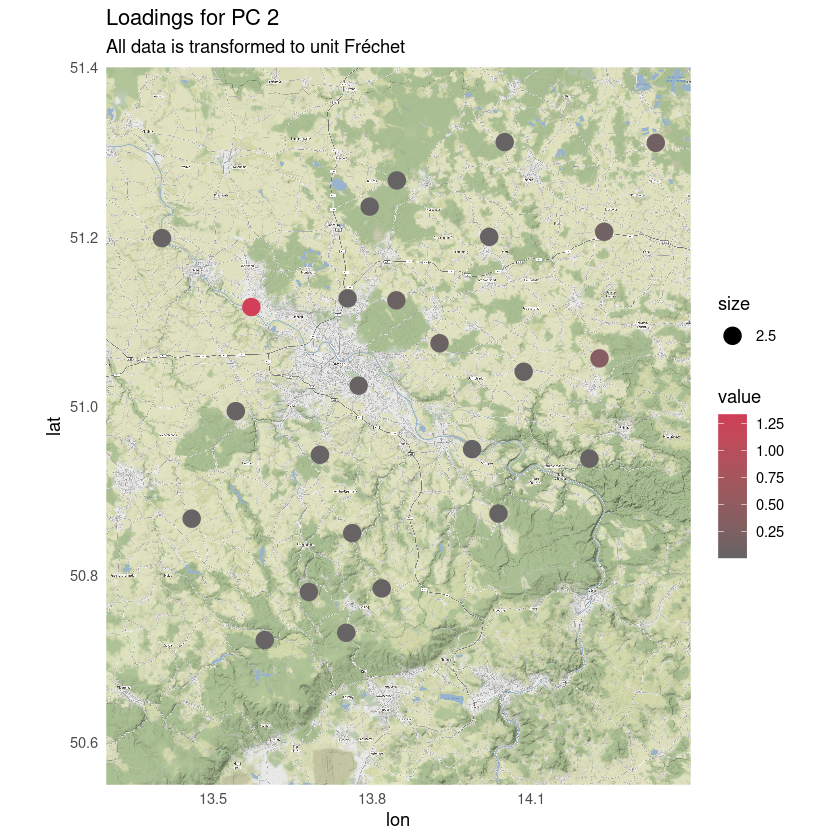

In [72]:
create_map_by_loadings(2)

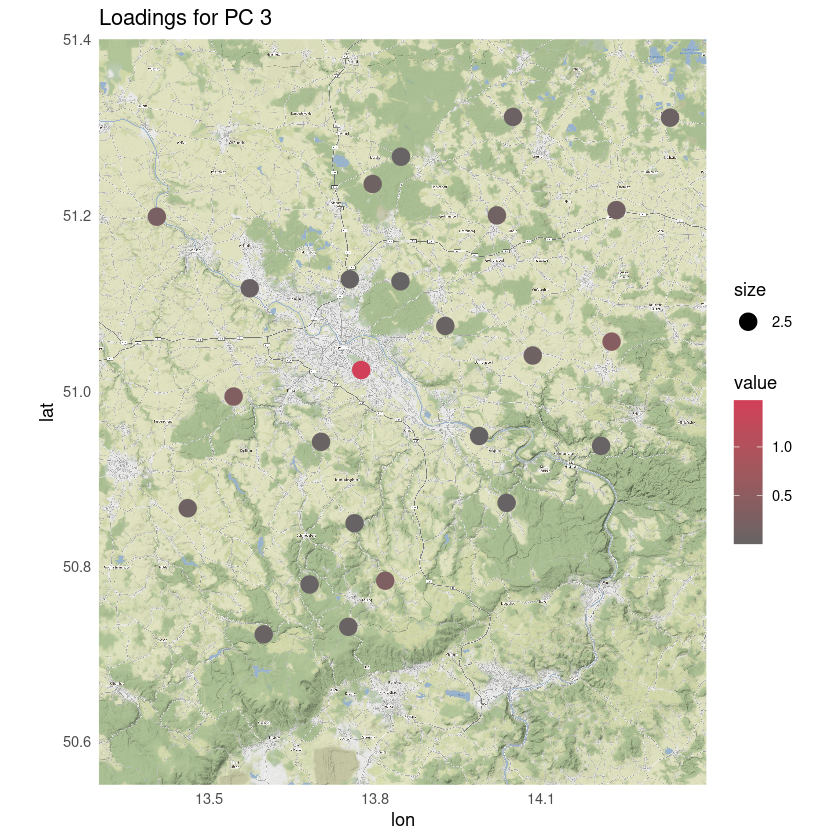

In [79]:
create_map_by_loadings(3)

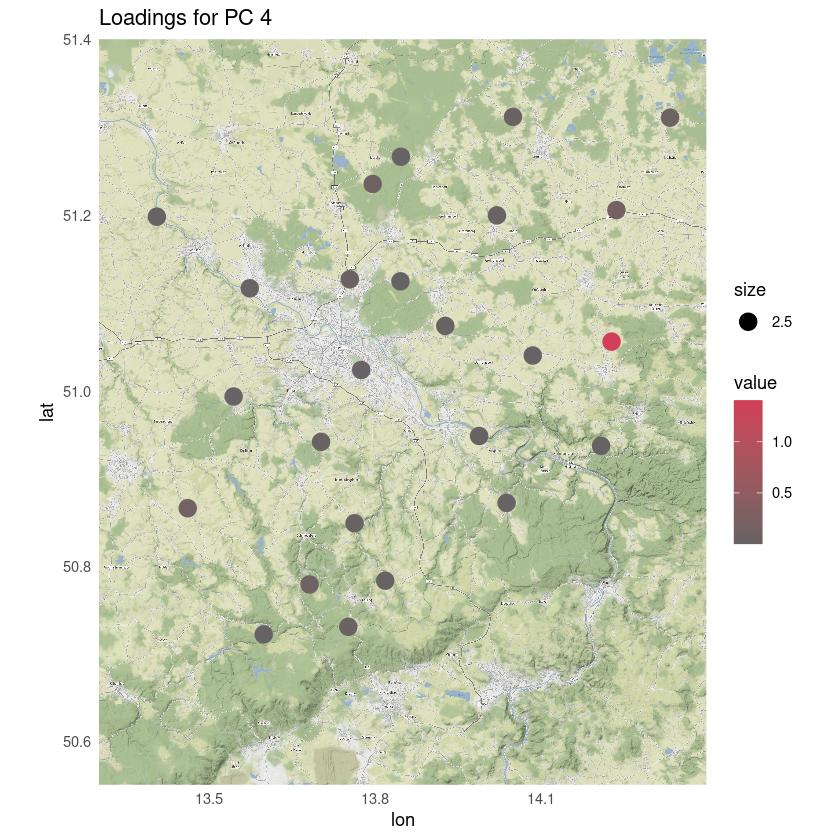

In [80]:
create_map_by_loadings(4)

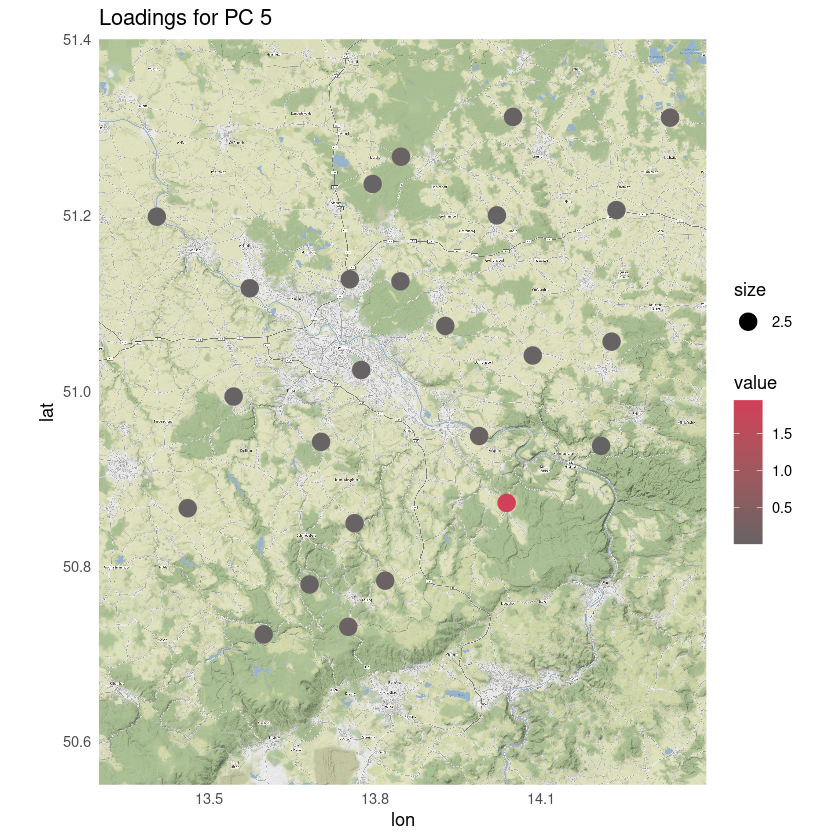

In [81]:
create_map_by_loadings(5)

# create the compact representation and reconstrcution 

This is done with a functions simpliar to *predict(model, data, ...)* which are called *compress(model, data)* and *reconstruct(model, compressed_data)*. 

In [14]:
compr <- compress(maxPCA, data_pca_f1)
reconstr <- reconstruct(maxPCA, compr)

# Look at the data vs. the reconstructed data.

In [15]:
head(reconstr)

[,1]      [,2]     [,3]      [,4]     [,5]     [,6]     [,7]     [,8]     
[1,] 3.4583890 2.194195  5.133927 1.552661 2.448082 1.333864 2.288775 1.4065574
[2,] 0.7739231 1.462260  1.469240 1.252764 1.975233 0.894084 1.534157 0.9428103
[3,] 0.7739231 1.462260  1.351910 1.252764 1.975233 0.894084 1.534157 0.9428103
[4,] 0.7739231 1.462260  1.351910 1.252764 1.975233 0.894084 1.534157 0.9428103
[5,] 3.1958676 4.427006 10.227134 3.076350 4.850482 2.685659 4.608318 2.8320237
[6,] 1.1216174 1.892764  2.850451 1.654898 2.609279 1.492367 2.560751 1.5736992
     [,9]      [,10]     [,11] [,12]     [,13]     [,14]    [,15]     [,16]    
[1,] 1.3114949 0.9383061 ⋯     1.2517135 2.4381608 3.966969 1.1711718 1.3622110
[2,] 0.8790902 0.6253079 ⋯     0.8341695 0.6232529 1.135277 0.7804947 0.9713858
[3,] 0.8790902 0.6253079 ⋯     0.8341695 0.6232529 1.044617 0.7804947 0.9713858
[4,] 0.8790902 0.6253079 ⋯     0.8341695 0.6232529 1.044617 0.7804947 0.9713858
[5,] 2.6406207 1.8931258 ⋯     2.5254563 2.2530835 7.902474 2.3629554 2.7427347
[6,] 1.4673404 0.8094050 ⋯     1.0797576 1.0403075 2.202534 1.0102804 1.5240831
     [,17]    [,18]     [,19]     [,20]     [,21]   
[1,] 1.519899 1.1330891 1.3056997 1.6492222 6.003953
[2,] 1.226329 0.7551156 0.8752057 0.9442363 1.343573
[3,] 1.226329 0.7551156 0.8752057 0.9442363 1.343573
[4,] 1.226329 0.7551156 0.8752057 0.9442363 1.343573
[5,] 3.011437 2.2861199 2.6289524 3.2853638 5.548202
[6,] 1.619979 0.9774295 1.4608565 1.2473342 1.947190

In [16]:
head(data_pca_f1)

SDO_04432 SDO_00457 SDO_00483 SDO_00822 SDO_00878 SDO_01048 SDO_01051
[1,] 3.940980  2.194188   5.133933 1.812126  2.448080  2.210930  2.288783 
[2,] 1.265307  1.462255   1.469242 1.640387  1.975231  1.713091  1.534163 
[3,] 1.076778  1.462255   1.351912 1.640387  1.975231  1.713091  1.534163 
[4,] 1.076778  1.462255   1.351912 1.640387  1.975231  1.713091  1.534163 
[5,] 6.245923  4.426992  10.227147 4.053397  4.850479  3.813087  4.608335 
[6,] 1.943690  1.892758   2.850454 2.044385  2.609277  1.961120  2.560760 
     SDO_01651 SDO_02030 SDO_03094 ⋯ SDO_02985 SDO_03683 SDO_15819 SDO_04023
[1,] 4.135481  4.135481  2.227872  ⋯ 6.533582  4.123577  3.408778  3.522940 
[2,] 1.651288  1.526762  1.626902  ⋯ 1.559185  1.187115  1.632277  1.571903 
[3,] 1.651288  1.526762  1.626902  ⋯ 1.559185  1.187115  1.632277  1.571903 
[4,] 1.651288  1.526762  1.626902  ⋯ 1.559185  1.187115  1.632277  1.571903 
[5,] 6.533582  6.758591  5.757010  ⋯ 4.726635  4.308719  7.636412  4.076556 
[6,] 2.059409  2.418719  2.513680  ⋯ 1.892758  1.882808  2.687761  2.457993 
     SDO_04047 SDO_02317 SDO_04895 SDO_02622 SDO_05746 SDO_05779
[1,] 2.653662  2.875933  1.616224  1.754136  2.404247  6.003984 
[2,] 1.514534  1.559185  1.616224  1.754136  1.651288  1.314793 
[3,] 1.514534  1.559185  1.616224  1.754136  1.651288  1.314793 
[4,] 1.514534  1.559185  1.616224  1.754136  1.651288  1.314793 
[5,] 6.098661  5.957650  5.609313  4.866369  4.308719  3.391775 
[6,] 2.443147  2.074599  2.869528  2.544911  1.968157  1.314793

# Looking at the whole dataset with the real extreme event 

In [17]:
dat_pca <- as_tibble(data_pca_f1)
dat_reconstr <- as_tibble(reconstr)
names(dat_reconstr) <- names(dat_pca)

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


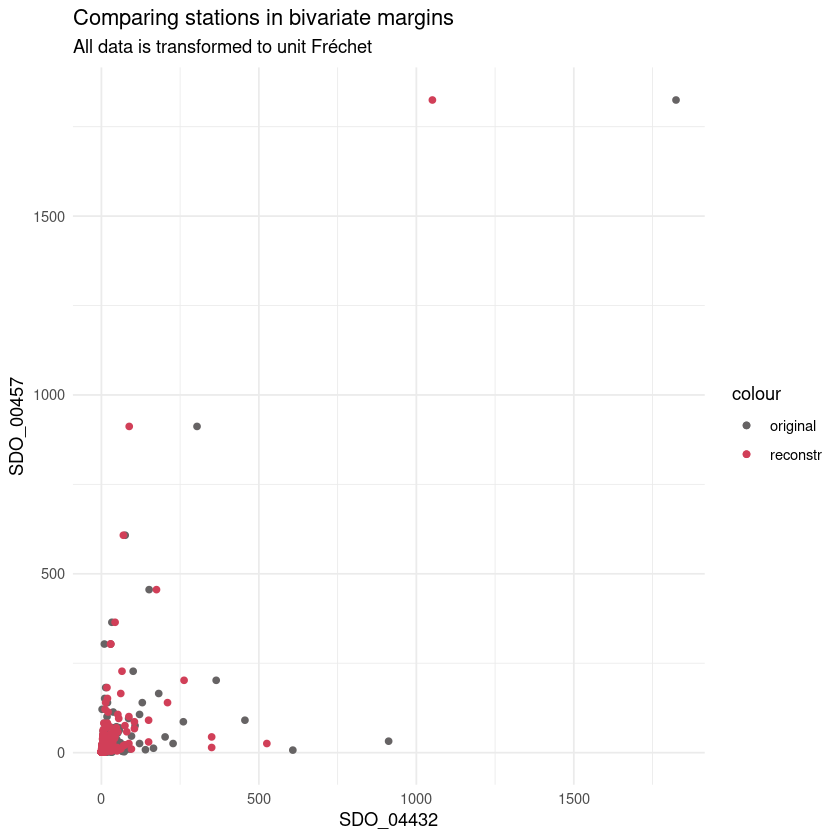

In [18]:
p1 <- ggplot(dat_pca, aes(x = SDO_04432, y = SDO_00457, color = "original")) +
geom_point() +
geom_point(aes(x = SDO_04432, y = SDO_00457, color = "reconstr"), data = dat_reconstr) +
scale_color_manual(values = c("#666364", "#D13F58")) + 
labs(title = "Comparing stations in bivariate margins", subtitle = "All data is transformed to unit Fréchet") +
theme_minimal()

p1

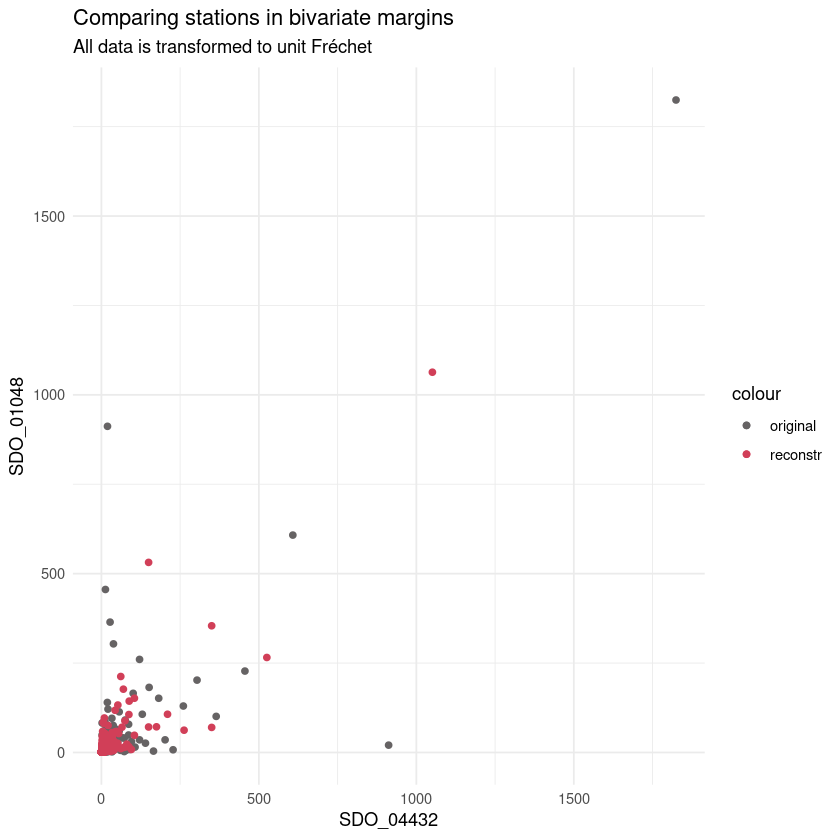

In [19]:
p2 <- ggplot(dat_pca, aes(x = SDO_04432, y = SDO_01048, color = "original")) +
geom_point() +
geom_point(aes(x = SDO_04432, y = SDO_01048, color = "reconstr"), data = dat_reconstr) +
scale_color_manual(values = c("#666364", "#D13F58")) + 
labs(title = "Comparing stations in bivariate margins", subtitle = "All data is transformed to unit Fréchet") +
theme_minimal()

p2

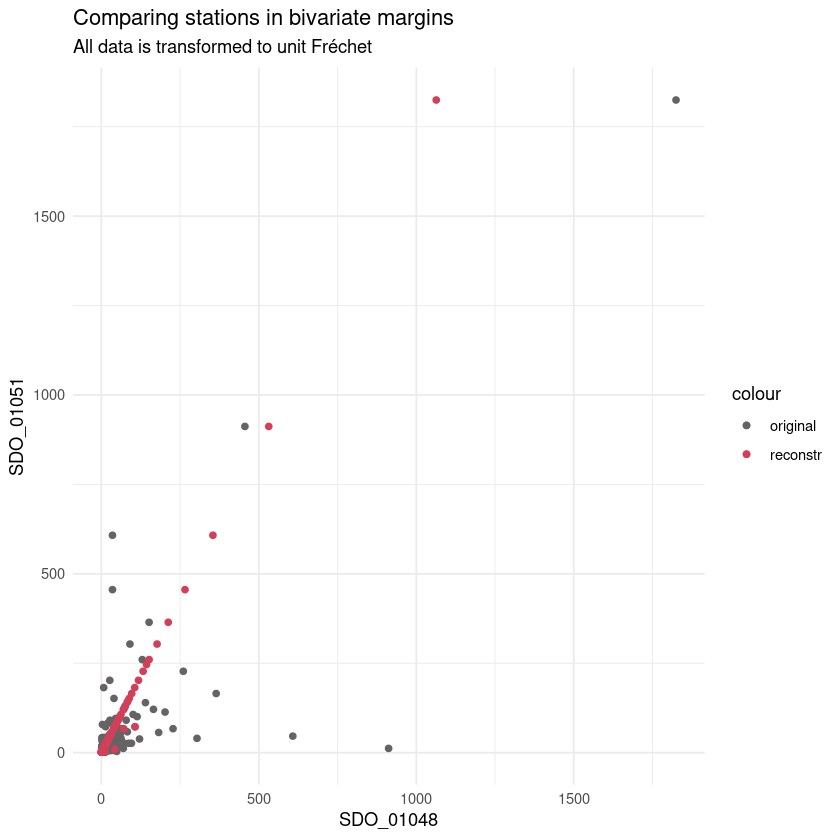

In [20]:
p3 <- ggplot(dat_pca, aes(x = SDO_01048, y = SDO_01051, color = "original")) +
geom_point() +
geom_point(aes(x = SDO_01048, y = SDO_01051, color = "reconstr"), data = dat_reconstr) +
scale_color_manual(values = c("#666364", "#D13F58")) + 
labs(title = "Comparing stations in bivariate margins",
     subtitle = "All data is transformed to unit Fréchet") +
theme_minimal()

p3

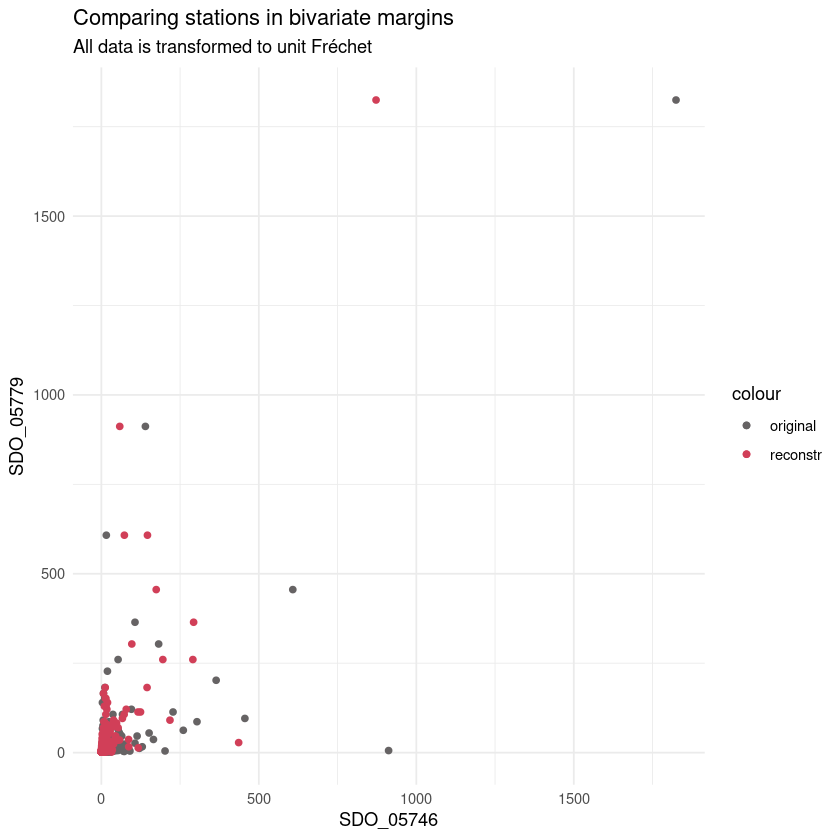

In [21]:
p4 <- ggplot(dat_pca, aes(x = SDO_05746, y = SDO_05779, color = "original")) +
geom_point() +
geom_point(aes(x = SDO_05746, y = SDO_05779, color = "reconstr"), data = dat_reconstr) +
scale_color_manual(values = c("#666364", "#D13F58")) + 
labs(title = "Comparing stations in bivariate margins",
     subtitle = "All data is transformed to unit Fréchet") +
theme_minimal()

p4

In [23]:
library(gridExtra)

dat_reconstr$date <- rain_df_dresden$date
dat_pca$date <- rain_df_dresden$date


create_map_by_day <- function(dateinput) {
    
    internal_geodat_orig <- dresden_geodat
    internal_geodat_rec <- dresden_geodat
    
    internal_geodat_orig$value <- 0
    internal_geodat_rec$value <- 0
    
    for(i in 1:dim(dresden_geodat)[1]) {
        internal_geodat_orig$value[i] <- unlist((dat_pca %>% filter(date == dateinput))[, id_int_to_colname(internal_geodat_orig$id[i])])
        internal_geodat_rec$value[i] <- unlist((dat_reconstr %>% filter(date == dateinput))[, id_int_to_colname(internal_geodat_rec$id[i])])
    }
     

    
    map_orig <- ggmap(dresden_map) +
    geom_point(internal_geodat_orig, mapping = aes(x = lon, y = lat, size = 2.5, color = value)) + 
    scale_color_gradient2(low = "#100000", mid = "#666364", high = "#D13F58", midpoint = 30) + 
    labs(title = paste("Original data", dateinput), 
     subtitle = "All data is transformed to unit Fréchet") +
    theme_minimal()
    
    map_rec <- ggmap(dresden_map) +
    geom_point(internal_geodat_rec, mapping = aes(x = lon, y = lat, size = 2.5, color = value)) + 
    scale_color_gradient2(low = "#100000", mid = "#666364", high = "#D13F58", midpoint = 30) + 
    labs(title = paste("Reconstructed data", dateinput), 
     subtitle = "All data is transformed to unit Fréchet") +
    theme_minimal()
    
    return(grid.arrange(map_orig, map_rec, ncol = 2))
}


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Looking at the spatial behaviour of the PCA for certain days

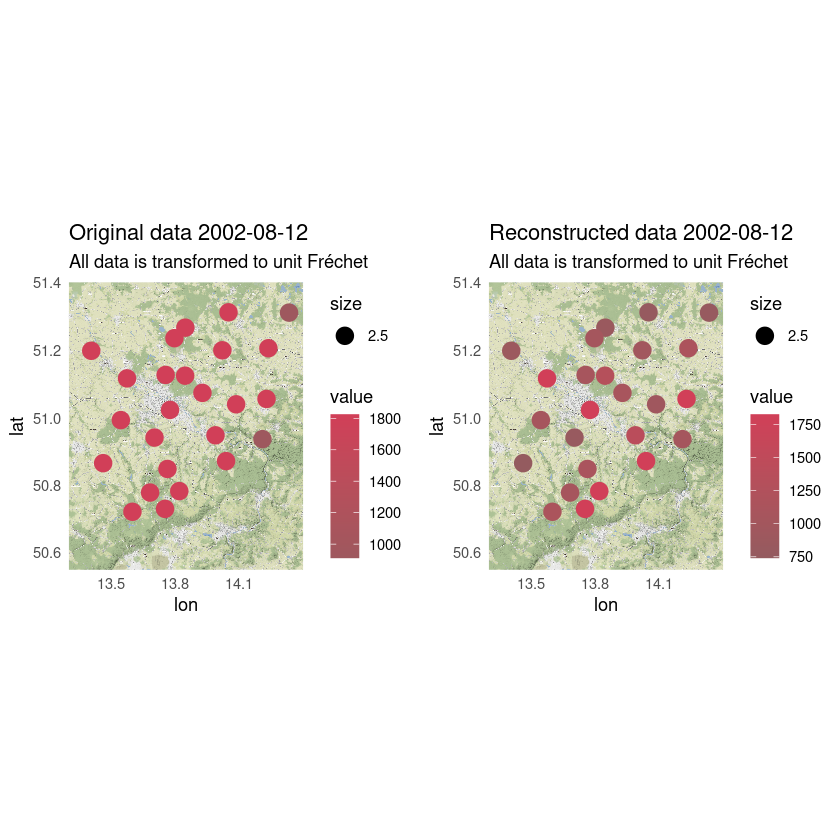

In [24]:
m1 <- create_map_by_day("2002-08-12")

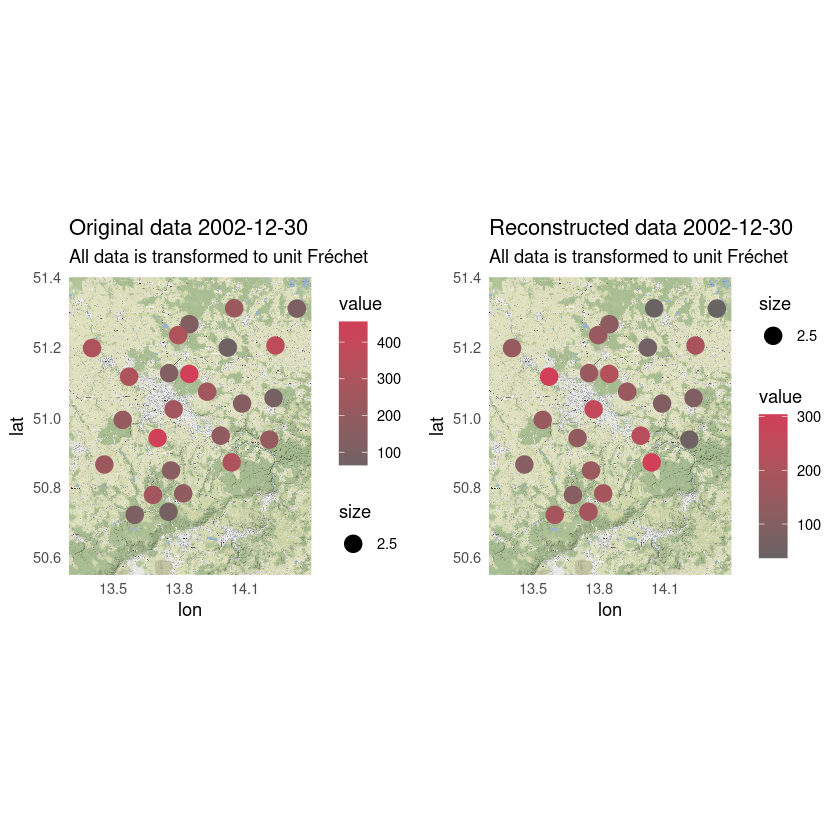

In [25]:
m2 <- create_map_by_day("2002-12-30")

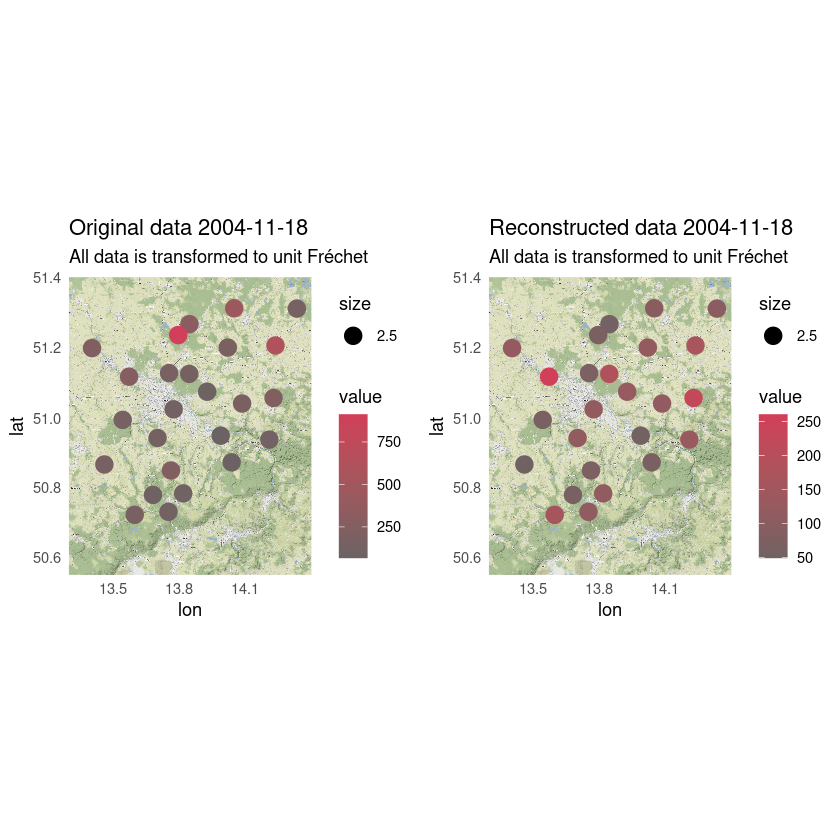

In [26]:
m3 <- create_map_by_day("2004-11-18")

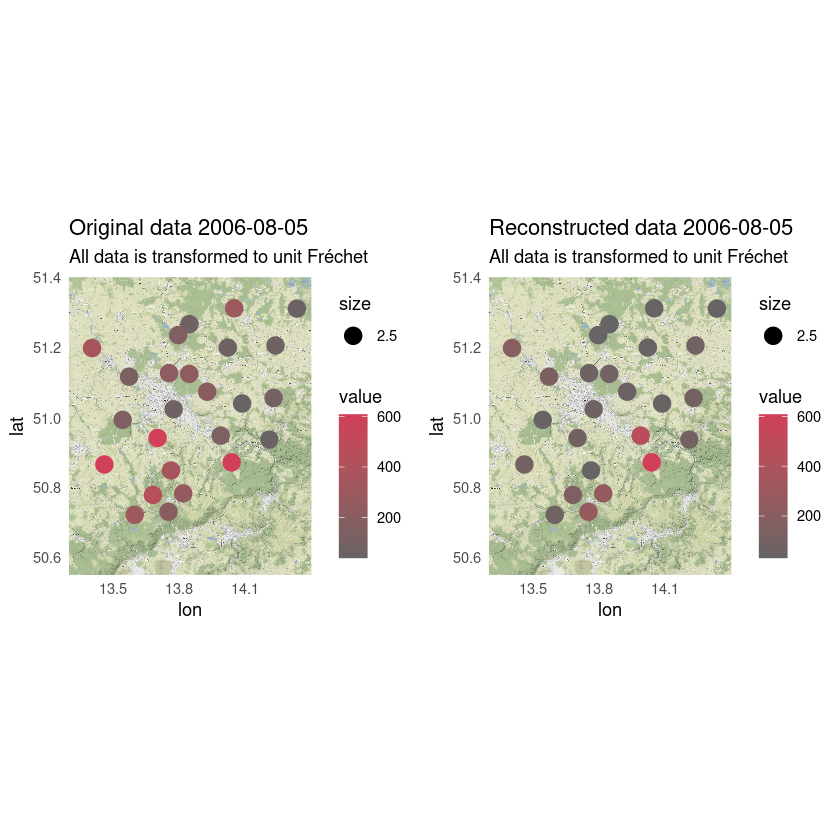

In [27]:
m4 <- create_map_by_day("2006-08-05")

# Looking at specific stations to see if the temporal fit looks reasonable

In [29]:
dat_pca$date <- as.POSIXct.default(dat_pca$date)
dat_reconstr$date <- as.POSIXct.default(dat_reconstr$date)


t1 <- ggplot(aes(x = date, y = SDO_01051, color = "SDO_01051"), data = dat_pca) +
geom_line() + 
geom_line(aes(x = date, y = SDO_01051, color = "reconstruction"), data = dat_reconstr) + 
scale_color_manual(values = c("#D13F58","#666364")) + 
labs(title = "temporal view on reconstruction") + 
theme_minimal()

t2 <- ggplot(aes(x = date, y = SDO_01651, color = "SDO_01651"), data = dat_pca) +
geom_line() + 
geom_line(aes(x = date, y = SDO_01651, color = "reconstruction"), data = dat_reconstr) + 
scale_color_manual(values = c("#D13F58","#666364")) + 
labs(title = "temporal view on reconstruction") + 
theme_minimal()

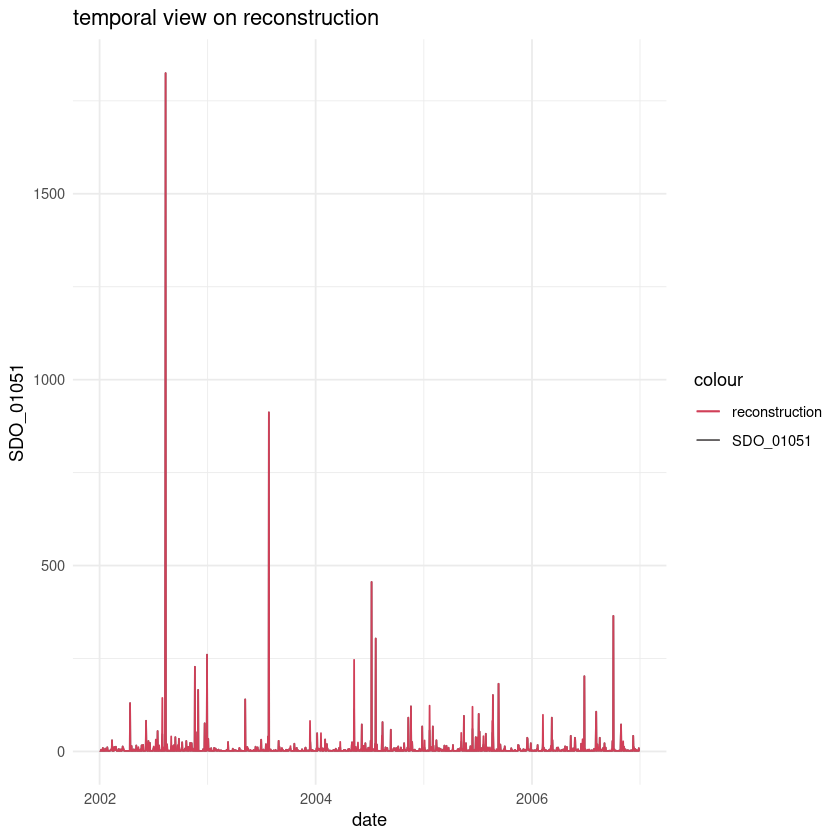

In [30]:
t1

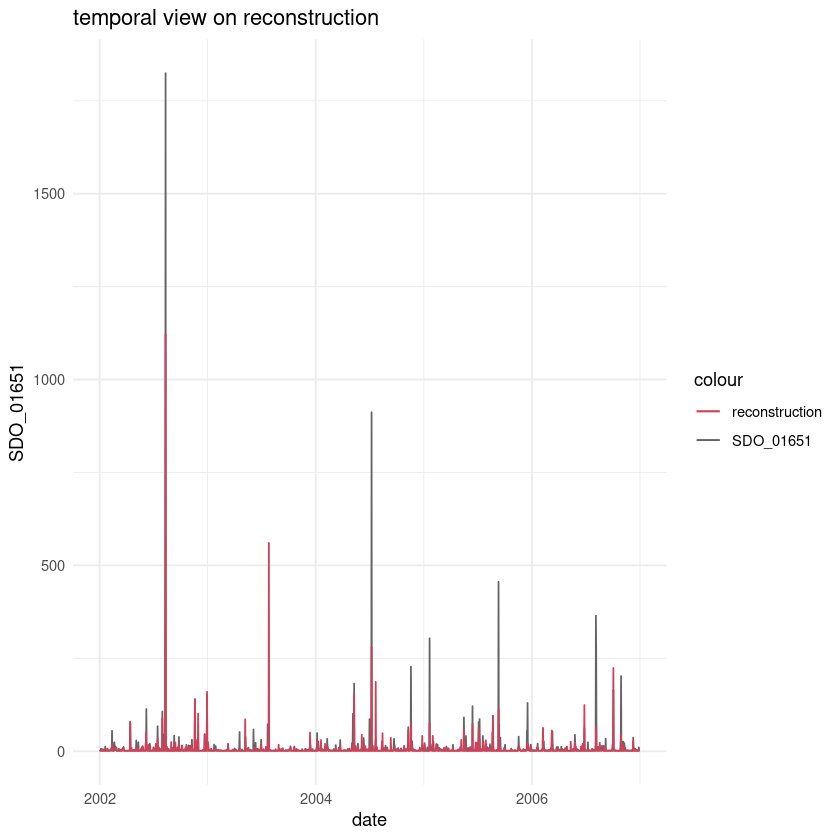

In [31]:
t2

In [32]:
reconstr_orig_margins <- transform_orig_margins(reconstr, data_pca)